# 2021-09-24 Transient problems

## Last time

* p-Laplacian
* algorithmic differentiation for matrix assembly
* principled by-hand differentiation

## Today

* recap/discuss methods for differentiating
* intro to ordinary differential equations
* accuracy and stability
* transient advection

In [4]:
using Plots
using LinearAlgebra
using SparseArrays
using Zygote

function vander(x, k=nothing)
    if k === nothing
        k = length(x)
    end
    V = ones(length(x), k)
    for j = 2:k
        V[:, j] = V[:, j-1] .* x
    end
    V
end

function fdstencil(source, target, k)
    "kth derivative stencil from source to target"
    x = source .- target
    V = vander(x)
    rhs = zero(x)'
    rhs[k+1] = factorial(k)
    rhs / V
end

function newton(residual, jacobian, u0; maxits=20)
    u = u0
    uhist = [copy(u)]
    normhist = []
    for k in 1:maxits
        f = residual(u)
        push!(normhist, norm(f))
        J = jacobian(u)
        delta_u = - J \ f
        u += delta_u
        push!(uhist, copy(u))
    end
    uhist, normhist
end

newton (generic function with 1 method)

# p-Laplacian with Zygote

In [69]:
function plaplace_fpoint(u, h)
    u_xstag = diff(u) / h
    kappa_stag = abs.(u_xstag) .^ (plaplace_p - 2)
    [1/h, -1/h]' * (kappa_stag .* u_xstag)
end

function plaplace_fzygote(u)
    n = length(u)
    h = 2 / (n - 1)
    u = copy(u)
    f = copy(u)
    u[[1, n]] = [0, 1]
    f[n] -= 1
    for i in 2:n-1
        f[i] = plaplace_fpoint(u[i-1:i+1], h) - plaplace_forcing
    end
    f
end

plaplace_fzygote (generic function with 1 method)

In [70]:
function plaplace_Jzygote(u)
    n = length(u)
    h = 2 / (n - 1)
    u = copy(u)
    u[[1, n]] = [0, 1]
    rows = [1, n]
    cols = [1, n]
    vals = [1., 1.] # diagonals entries (float)
    for i in 2:n-1
        js = i-1:i+1
        fi_ujs = gradient(ujs -> plaplace_fpoint(ujs, h), u[js])[1]
        mask = 1 .< js .< n
        append!(rows, [i,i,i][mask])
        append!(cols, js[mask])
        append!(vals, fi_ujs[mask])
    end
    sparse(rows, cols, vals)
end

plaplace_Jzygote (generic function with 1 method)

# Test it out

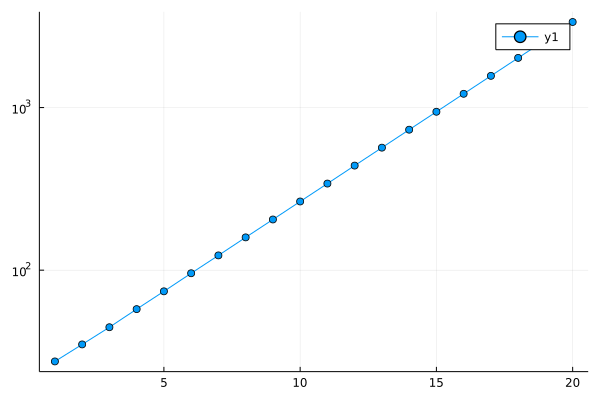

In [78]:
plaplace_p = 1.3
plaplace_forcing = .1
x = LinRange(-1, 1, 20)
u0 = collect(1 .+ x)
uhist, normhist = newton(plaplace_fzygote, plaplace_Jzygote, u0; maxits=20);
plot(normhist, marker=:auto, yscale=:log10)

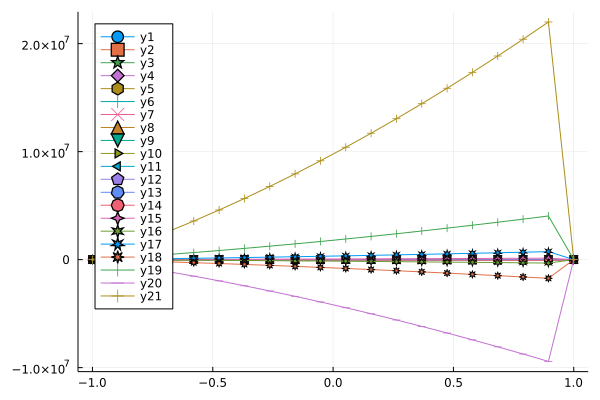

In [79]:
plot(x, uhist, marker=:auto, legend=:topleft)

* Can you fix the `plaplace_J` to differentiate correctly (analytically)?
* What is causing Newton to diverge?
* How might we fix or work around it?

# A model problem

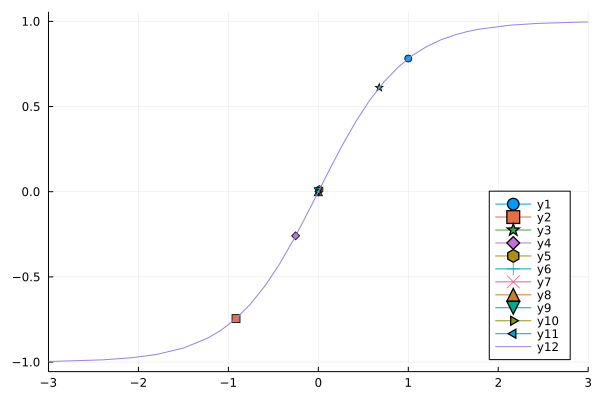

In [81]:
k = 1.05
fk(x) = tanh.(k*x)
Jk(x) = reshape(k / cosh.(k*x).^2, 1, 1)
xhist, normhist = newton(fk, Jk, [1.], maxits=10)
plot(xhist, fk.(xhist), marker=:auto, legend=:bottomright)
plot!(fk, xlims=(-3, 3))

# What about symbolic differentiation?

In [82]:
import Symbolics: Differential, expand_derivatives, @variables
@variables x
Dx = Differential(x)
y = tanh(k*x)
Dx(y)

Differential(x)(tanh(1.05x))

In [83]:
expand_derivatives(Dx(y))

1.05 - 1.05(tanh(1.05x)^2)

# Cool, what about products?

In [84]:
y = x
for _ in 1:2
    y = cos(y^pi) * log(y)
end
expand_derivatives(Dx(y))

((x^-1)*cos(x^π) - 3.141592653589793(x^2.141592653589793)*log(x)*sin(x^π))*(log(x)^-1)*(cos(x^π)^-1)*cos((log(x)^3.141592653589793)*(cos(x^π)^3.141592653589793)) - (3.141592653589793(x^-1)*(log(x)^2.141592653589793)*(cos(x^π)^3.141592653589793) - 9.869604401089358(x^2.141592653589793)*(log(x)^3.141592653589793)*(cos(x^π)^2.141592653589793)*sin(x^π))*sin((log(x)^3.141592653589793)*(cos(x^π)^3.141592653589793))*log(log(x)*cos(x^π))

* The size of these expressions can grow **exponentially**.

# Hand coding derivatives: it's all chain rule and associativity
$$ df = f'(x) dx $$

In [86]:
function f(x)
    y = x
    for _ in 1:2
        a = y^pi
        b = cos(a)
        c = log(y)
        y = b * c
    end
    y
end

f(1.9), gradient(f, 1.9)

(-1.5346823414986814, (-34.03241959914049,))

In [87]:
function df(x, dx)
    y = x
    dy = dx
    for _ in 1:2
        a = y^pi
        da = pi * y^(pi-1) * dy
        b = cos(a)
        db = -sin(a) * da
        c = log(y)
        dc = 1/y * dy
        y = b * c
        dy = db * c + b * dc
    end
    dy
end

df(1.9, 1)

-34.03241959914048

# We can go the other way

We can differentiate a composition $h(g(f(x)))$ as

\begin{align}
  \operatorname{d} h &= h' \operatorname{d} g \\
  \operatorname{d} g &= g' \operatorname{d} f \\
  \operatorname{d} f &= f' \operatorname{d} x.
\end{align}

What we've done above is called "forward mode", and amounts to placing the parentheses in the chain rule like

$$ \operatorname d h = \frac{dh}{dg} \left(\frac{dg}{df} \left(\frac{df}{dx} \operatorname d x \right) \right) .$$

The expression means the same thing if we rearrange the parentheses,

$$ \operatorname d h = \left( \left( \left( \frac{dh}{dg} \right) \frac{dg}{df} \right) \frac{df}{dx} \right) \operatorname d x $$

which we can compute with in reverse order via

$$ \underbrace{\bar x}_{\frac{dh}{dx}} = \underbrace{\bar g \frac{dg}{df}}_{\bar f} \frac{df}{dx} .$$

# A reverse mode example

$$ \underbrace{\bar x}_{\frac{dh}{dx}} = \underbrace{\bar g \frac{dg}{df}}_{\bar f} \frac{df}{dx} .$$

In [88]:
function g(x)
    a = x^pi
    b = cos(a)
    c = log(x)
    y = b * c
    y
end
(g(1.4), gradient(g, 1.4))

(-0.32484122107701546, (-1.2559761698835525,))

In [89]:
function gback(x, y_)
    a = x^pi
    b = cos(a)
    c = log(x)
    y = b * c
    # backward pass
    c_ = y_ * b 
    b_ = c * y_
    a_ = -sin(a) * b_
    x_ = 1/x * c_ + pi * x^(pi-1) * a_
    x_
end
gback(1.4, 1)

-1.2559761698835525

# Kinds of algorithmic differentation

* Source transformation: Fortran code in, Fortran code out
  * Duplicates compiler features, usually incomplete language coverage
  * Produces efficient code
* Operator overloading: C++ types
  * Hard to vectorize
  * Loops are effectively unrolled/inefficient
* Just-in-time compilation: tightly coupled with compiler
  * JIT lag
  * Needs dynamic language features (JAX) or tight integration with compiler (Zygote, Enzyme)
  * Some [sharp bits](https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html#control-flow)

# How does Zygote work?

In [92]:
h1(x) = x^3 + 3*x
h2(x) = ((x * x)  + 3) * x
@code_llvm h2(4.)

;  @ In[92]:2 within `h2'
define double @julia_h2_16295(double %0) {
top:
; ┌ @ float.jl:332 within `*'
   %1 = fmul double %0, %0
; └
; ┌ @ promotion.jl:321 within `+' @ float.jl:326
   %2 = fadd double %1, 3.000000e+00
; └
; ┌ @ float.jl:332 within `*'
   %3 = fmul double %2, %0
; └
  ret double %3
}


In [97]:
@code_llvm gradient(h2, 4.)

;  @ /home/jed/.julia/packages/Zygote/nsu1Y/src/compiler/interface.jl:74 within `gradient'
define [1 x double] @julia_gradient_16320(double %0) {
top:
;  @ /home/jed/.julia/packages/Zygote/nsu1Y/src/compiler/interface.jl:75 within `gradient'
; ┌ @ /home/jed/.julia/packages/Zygote/nsu1Y/src/compiler/interface.jl:40 within `pullback'
; │┌ @ /home/jed/.julia/packages/Zygote/nsu1Y/src/compiler/interface.jl:34 within `_pullback' @ In[92]:2 @ /home/jed/.julia/packages/Zygote/nsu1Y/src/compiler/interface2.jl:9
; ││┌ @ /home/jed/.julia/packages/Zygote/nsu1Y/src/compiler/interface2.jl within `macro expansion'
; │││┌ @ /home/jed/.julia/packages/Zygote/nsu1Y/src/compiler/chainrules.jl:152 within `chain_rrule'
; ││││┌ @ /home/jed/.julia/packages/ChainRulesCore/Voykb/src/rules.jl:134 within `rrule' @ /home/jed/.julia/packages/ChainRules/3Qznz/src/rulesets/Base/fastmath_able.jl:222
; │││││┌ @ float.jl:332 within `*'
        %1 = fmul double %0, %0
; ││└└└└
; ││ @ /home/jed/.julia/packages/Zygote/nsu

# Forward or reverse?

It all depends on the shape.

$$ \operatorname d h = \frac{dh}{dg} \left(\frac{dg}{df} \left(\frac{df}{dx} \operatorname d x \right) \right) .$$

$$ \operatorname d h = \left( \left( \left( \frac{dh}{dg} \right) \frac{dg}{df} \right) \frac{df}{dx} \right) \operatorname d x $$

* One input, many outputs: use forward mode
  * "One input" can be looking in one direction
* Many inputs, one output: use reverse mode
  * Will need to traverse execution backwards ("tape")
  * Hierarchical checkpointing
* About square? Forward is usually a bit more efficient.

# Ordinary Differential Equations

Given initial condition $u_0 = u(t=0)$, find $u(t)$ for $t > 0$ that satisfies

$$ \dot u \equiv \frac{\partial u}{\partial t} = f(t, u) $$

| Application | $u$ | $f$ |
| --- | --- | --- |
| Orbital dynamics | position, momentum | conservation of momentum|
| Chemical reactions | concentration | conservation of atoms |
| Epidemiology | infected/recovered population | transmission and recovery |
| Heat transfer | temperature | conservation of energy |
| Seismology | displacement, momentum | conservative of momentum |

# Solving differential equations

## Linear equations

$$ \dot u = A(t) u + \text{source}(t)$$

* Autonomous if $A(t) = A$ and source independent of $t$

* Suppose $u$ and $a = A$ are scalars: $u(t) = e^{at} u_0$

## Can do the same for systems

$$ y(t) = e^{A t} y_0 $$

#### What does it mean to exponentiate a matrix?

Taylor series!

$$ e^A = 1 + A + \frac{A^2}{2} + \frac{A^3}{3!} + \dotsb $$
and there are many [practical ways to compute it](http://www.cs.cornell.edu/cv/ResearchPDF/19ways+.pdf).

#### Question
Suppose that the diagonalization $A = X \Lambda X^{-1}$ exists and derive a finite expression for the matrix exponential using the scalar `exp` function.

# Forward Euler method

In [99]:
function ode_euler(f, u0; tfinal=10., h=0.1)
    u = copy(u0)
    t = 0.
    thist = [t]
    uhist = [u0]
    while t < tfinal
        tnext = min(t+h, tfinal)
        h = tnext - t
        u += h * f(t, u)
        t = tnext
        push!(thist, t)
        push!(uhist, u)
    end
    thist, hcat(uhist...)
end

ode_euler (generic function with 1 method)

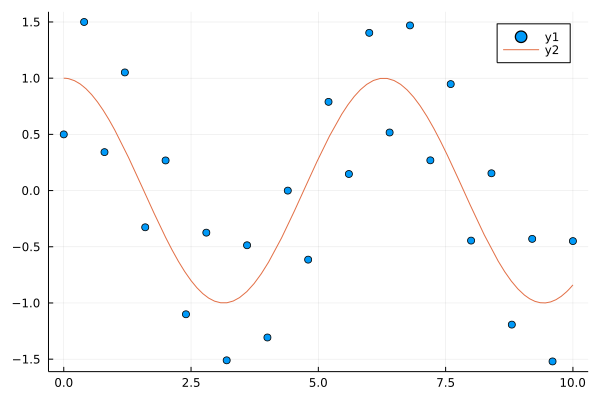

In [112]:
f1(t, u; k=5) = -k * (u .- cos(t))

thist, uhist = ode_euler(f1, [.5], tfinal=10, h=.4)
scatter(thist, uhist[1,:])
plot!(cos)

# Forward Euler on a linear system

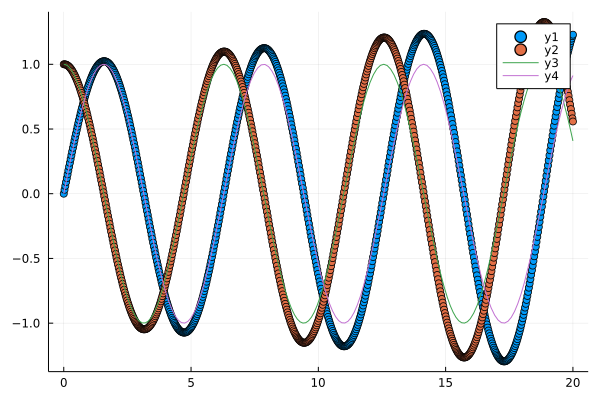

In [116]:
f2(t, u) = [0 1; -1 0] * u

thist, uhist = ode_euler(f2, [0., 1], h=.03, tfinal=20)
scatter(thist, uhist')
plot!([cos, sin])

In [117]:
eigen([0 1; -1 0])

Eigen{ComplexF64, ComplexF64, Matrix{ComplexF64}, Vector{ComplexF64}}
values:
2-element Vector{ComplexF64}:
 0.0 - 1.0im
 0.0 + 1.0im
vectors:
2×2 Matrix{ComplexF64}:
 0.707107-0.0im       0.707107+0.0im
      0.0-0.707107im       0.0+0.707107im

### Linear Stability Analysis

Why did Euler converge on the first problem (with sufficiently small steps) while always diverging on the second problem?

We can understand the convergence of methods by analyzing the test problem
$$ \dot u = \lambda u $$
for different values of $\lambda$ in the complex plane.
One step of the Euler method with step size $h$ maps
$$ u \to u + h \lambda u = \underbrace{(1 + h \lambda)}_{R(h \lambda)} u $$
where we have introduced the complex-valued function $R(z)$.

* When does this map cause solutions to "blow up" and when is it stable?

# Stability diagrams (a property of methods)

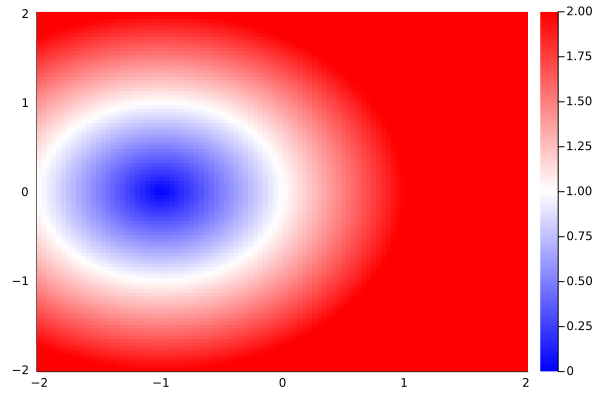

In [119]:
function plot_stability(Rz; xlims=(-2, 2), ylims=(-2, 2))
    x = LinRange(xlims[1], xlims[2], 100)
    y = LinRange(ylims[1], ylims[2], 100)
    heatmap(x, y, (x, y) -> abs(Rz(x + 1im*y)), c=:bwr, clims=(0, 2), axes=:equal)
end
plot_stability(z -> 1 + z)

## Implicit methods

Recall that forward Euler is the step
$$ \tilde u(h) = u(0) + h f(0, u(0)) . $$
This can be evaluated **explicitly**; all the terms on the right hand side are known so the approximation $\tilde u(h)$ is computed merely by evaluating the right hand side.
Let's consider an alternative, **backward Euler** (or "implicit Euler"),
$$ \tilde u(h) = u(0) + h f(h, \tilde u(h)) . $$
This is a (generally) nonlinear equation for $\tilde u(h)$.
For the test equation $\dot u = \lambda u$, the backward Euler method is
$$ \tilde u(h) = u(0) + h \lambda \tilde u(h) $$
or
$$ \tilde u(h) = \underbrace{\frac{1}{1 - h \lambda}}_{R(h\lambda)} u(0) . $$

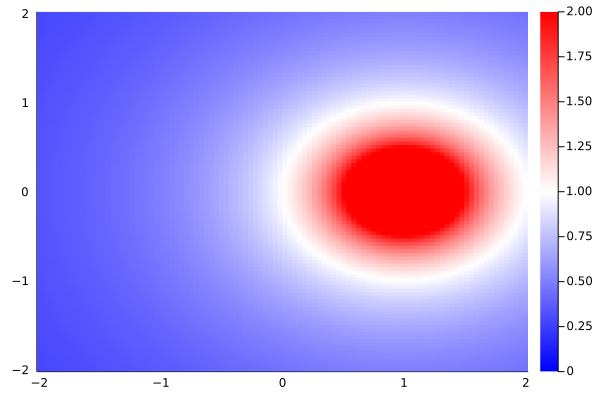

In [120]:
plot_stability(z -> 1 / (1 - z))

# Advection with centered stencil

In [121]:
function advect_center(t, u)
    n = length(u)
    dx = 2 / n
    uwrap = [u[end], u..., u[1]]
    f = zero(u)
    for i in 1:n
        f[i] = -(uwrap[i+2] - uwrap[i]) / (2*dx)
    end
    f
end

x = LinRange(-1, 1, 51)[1:end-1]
u0 = exp.(-9 * x .^ 2)
thist, uhist = ode_euler(advect_center, u0, h=.002, tfinal=1);

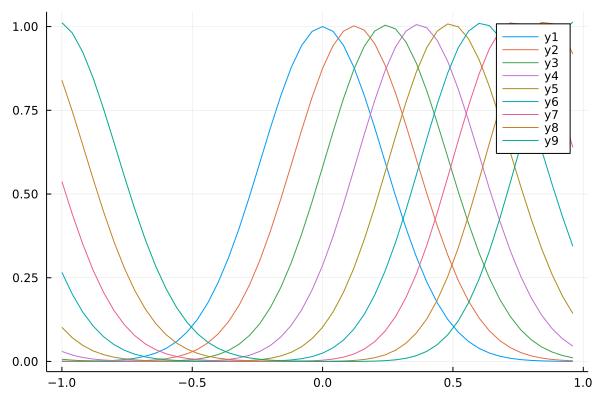

In [122]:
nsteps = size(uhist, 2)
plot(x, uhist[:, 1:(nsteps÷8):end])

# Advection with upwind stencil

In [123]:
function advect_upwind(t, u)
    n = length(u)
    dx = 2 / n
    uwrap = [u[end], u..., u[1]]
    f = zero(u)
    for i in 1:n
        f[i] = -(uwrap[i+1] - uwrap[i]) / dx
    end
    f
end

x = LinRange(-1, 1, 51)[1:end-1]
u0 = exp.(-9 * x .^ 2)
@time thist, uhist = ode_euler(advect_upwind, u0, h=.002, tfinal=1);

  0.073689 seconds (119.23 k allocations: 7.136 MiB, 96.56% compilation time)


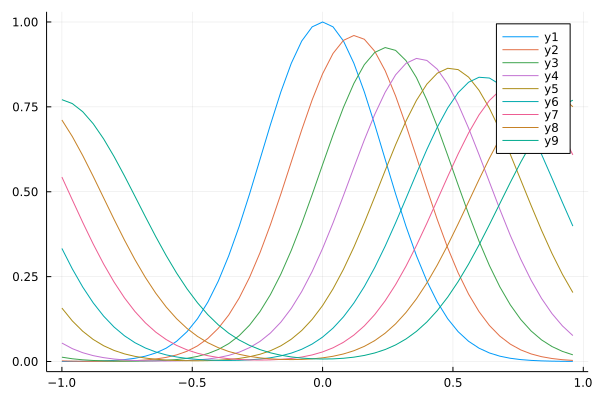

In [124]:
nsteps = size(uhist, 2)
plot(x, uhist[:, 1:(nsteps÷8):end])